# SD-TSIA204 Lab 2 : Linear Regression

*IQBI Hamza*

In [1]:
fn1 = "hamza"
ln1 = "iqbi"
filename = "_".join(map(lambda s: s.strip().lower(),
["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os import path
import pandas as pd
import scipy
import seaborn as sns
import plotly.express as px
from scipy.stats import t

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error as mse

#### Preprocessing :

In [3]:
# Setting the random seed to 0
np.random.seed(0)

In [59]:
# Loading the data
path.join('/Users/IQBI Hamza/OneDrive/Bureau/2A/TSIA/SD-TSIA204', 'TP2')
df = pd.read_csv('meatspec.csv', header = None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
1,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.8596,2.8394,2.8192,22.5
2,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.8606,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.196,3.17942,40.1
3,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
4,2.82286,2.8246,2.8263,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9


In [5]:
df = df.iloc[1:] # in order to remove the row with V_k and have numerical data only

Text(0.5, 1.0, 'The mean and standard deviation of all the covariates')

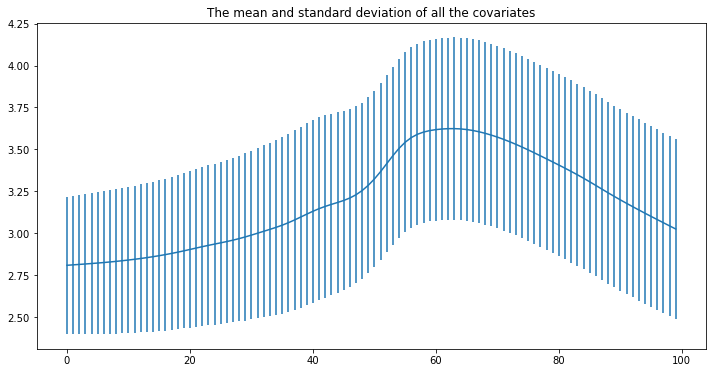

In [6]:
n, p = df.shape
for i in range(p) :
    df[i] = pd.to_numeric(df[i], errors='coerce') # to convert the type of the data to numeric
    
# In order to get the mean and std of the covariates, we need to remove the column 'fat'
means = np.array(df.iloc[:, :p-1]).mean(axis=0, dtype=np.float64) 
stds = np.array(df.iloc[:, :p-1]).std(axis=0, dtype=np.float64)

plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(p-1), means, stds)
plt.title("The mean and standard deviation of all the covariates")

It's clear that the data is :

1.*Not centered*, since the mean is not 0.

2.*Not normalized*, since it has values out of the segment [0, 1]. 

3.*Not standarized* since it's not centered (and also the standard deviation is not 1).

In [7]:
X = np.array(df.iloc[:, :p-1])
Y = np.array(df[100]) # The variable that we seek to predict its value : fat

# Separating the data into train and test sets 
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.25, train_size = 0.75)

# Standarazing both training and testing sets

scaler = StandardScaler()
# The test set must use identical scaling to the training set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
#Use only the training set to calculate the mean and variance, standarize the training set, and then at test time,
#use that same (training) mean and variance to normalize the test set
Y_train = scaler.fit_transform(Y_train.reshape(-1, 1))
Y_test = scaler.transform(Y_test.reshape(-1, 1))


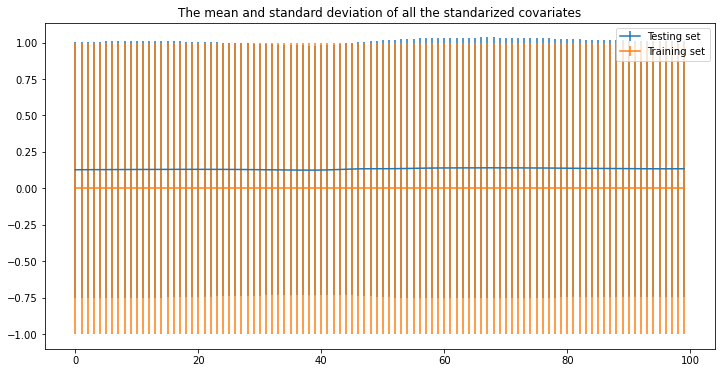

In [8]:
standard_means_train = np.array(X_train).mean(axis=0, dtype=np.float64) 
standard_stds_train = np.array(X_train).std(axis=0, dtype=np.float64)

standard_means_test = np.array(X_test).mean(axis=0, dtype=np.float64) 
standard_stds_test = np.array(X_test).std(axis=0, dtype=np.float64)

plt.figure(figsize = (12, 6))
plt.errorbar(np.arange(p-1), standard_means_test, standard_stds_test, label = 'Testing set')
plt.errorbar(np.arange(p-1), standard_means_train, standard_stds_train, label = 'Training set')
plt.title("The mean and standard deviation of all the standarized covariates")
plt.legend()

In [9]:
def r_2(Y_predicted, Y_groud_truth) :
    Y_bar = np.mean(Y_groud_truth)
    return 1 - np.linalg.norm(Y_predicted - Y_groud_truth)**2 / np.linalg.norm(Y_groud_truth - Y_bar)**2

In [10]:
# Fitting a regular OLS

regression = LinearRegression(fit_intercept = False)
attributes = regression.fit(X_train, Y_train) 

In [11]:
Y_predicted = attributes.predict(X_test)
r2_OLS = r_2(Y_predicted, Y_test)
df_coef = pd.DataFrame({'Regular OLS' : [r2_OLS]})
df_coef

,Regular OLS
0,0.960055


#### Variable selection :
##### Q2 :

In [12]:
def f_variable_selection(X, Y, p_stop = None, stop_cirterion = False) :
    
    ''' Performs forward variable selection on the training input data X and training output data Y
        Returns :
           + S : a list containing the selected variables in order
           + p_values : their respective p-values
           + S_stop : a list containing the selected variables, in order, based on the stop criterion
    '''
    
    n, p = X.shape
    S = [] # To store all the variables, in their order of 'importance'
    S_stop = [] # To store all the variables with a p-value smaller than p_stop
    p_values = []
    r = Y
       
    while len(S) < p :
        T = {}
        Thetas = {}
        for k in range(p) : 
            # Each k define a submodel --> the covariates are "competing" one against the other
            if k not in S :
                X_ = np.stack((np.ones(n), X[:, k]), axis = 1)
                reg = LinearRegression(fit_intercept = True)
                reg.fit(X_, r)
                theta_hat = reg.coef_.T
                Gram_hat = X_.T @ X_ / n # The Gram matrix
                s_hat = np.sqrt(np.linalg.inv(Gram_hat)[0][0])
                sigma_hat = np.linalg.norm(r - X_ @ theta_hat)**2 / (n-2) # The noise
                # The statistic used for the test of no-effect
                # The larger the statistic, the more important the effect of the k-th variable
                T_hat = (np.sqrt(n)*np.linalg.norm(theta_hat, 1)) / (s_hat * sigma_hat)
                T[k] = T_hat
                Thetas[k] = theta_hat
        k_star = max(T, key = T.get)
        p_value = 2*(1 - scipy.stats.norm.cdf(T[k_star])) # In the random design model, since we don't study the residuals
        if stop_cirterion :
            if p_value < p_stop : S_stop.append(k_star)
        p_values.append(p_value)
        S.append(k_star)
        r = r - np.stack((np.ones(n), X[:, k_star]), axis = 1) @ Thetas[k_star] 
        # Replacing the output by the residual : account for the predictive information it brought in the modelling of Y
    
    return S, p_values, S_stop

In [13]:
S = f_variable_selection(X_train, Y_train)[0]
p_values = f_variable_selection(X_train, Y_train)[1]
print(f"The selected variables are, in their selection order : {S}")

The selected variables are, in their selection order : [40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98, 13, 34, 1, 44, 0, 95, 14, 33, 15, 99, 16, 32, 17, 94, 18, 93, 19, 45, 64, 31, 65, 92, 63, 91, 66, 90, 67, 30, 20, 89, 62, 88, 68, 46, 61, 87, 69, 86, 60, 85, 53, 29, 52, 84, 70, 83, 54, 28, 59, 82, 21, 47, 55, 81, 58, 27, 51, 80, 71, 26, 56, 79, 57, 48, 72, 78, 50, 25, 22, 77, 73, 24, 74, 76, 75, 49, 23]


##### Q3 :

In [14]:
#----- Applying the OLS with the selected vairables -----#

S_stop = f_variable_selection(X_train, Y_train, 0.05, stop_cirterion=True)[2]
X_train_fvs = []
X_test_fvs = []
for k in range(len(S_stop)) :
    X_train_fvs.append(X_train[:, S_stop[k]])
    X_test_fvs.append(X_test[:, S_stop[k]])
    
X_train_fvs = np.array(X_train_fvs).T
X_test_fvs = np.array(X_test_fvs).T

variable_selection_reg = LinearRegression(fit_intercept=False)
variable_selection_reg.fit(X_train_fvs, Y_train)
Y_predicted_vs = variable_selection_reg.predict(X_test_fvs)

# Storing the R² coefficient in the data frame
r2_variable_selection = r_2(Y_predicted_vs, Y_test)
df_coef["Forward variable selection"] = r2_variable_selection
print(f"The number of variables selcted by the FVS, with stopping critrion being p_value < 0.05 is : {len(S_stop)}")
df_coef

The number of variables selcted by the FVS, with stopping critrion being p_value < 0.05 is : 23


,Regular OLS,Forward variable selection
0,0.960055,0.95518


#### Q4 :

In [15]:
#----- Fitting the Sequential Feature Selector of sklearn -----#

sfs = SequentialFeatureSelector(estimator = LinearRegression(fit_intercept=False), n_features_to_select=len(S_stop))
sfs.fit(X_train, Y_train)

support = sfs.support_
sequential_selected = []
for k in range(len(support)) :
    if support[k] == True : sequential_selected.append(k)
print(f"The sequentially selected variables are :  {sequential_selected}")
print(f"The forward selected variables are : {S_stop}")

The sequentially selected variables are :  [0, 1, 3, 18, 19, 21, 34, 35, 39, 40, 43, 46, 47, 48, 49, 57, 72, 74, 82, 87, 90, 97, 99]
The forward selected variables are : [40, 7, 39, 6, 41, 8, 38, 5, 42, 9, 37, 4, 36, 10, 97, 3, 43, 11, 35, 2, 96, 12, 98]


In [16]:
#----- Applying the OLS with the sequentially selected vairables -----#

X_train_sfs = []
X_test_sfs = []
for k in range(len(sequential_selected)) :
    X_train_sfs.append(X_train[:, sequential_selected[k]])
    X_test_sfs.append(X_test[:, sequential_selected[k]])
    
X_train_sfs = np.array(X_train_sfs).T
X_test_sfs = np.array(X_test_sfs).T

sfs_reg = LinearRegression(fit_intercept=False)
sfs_reg.fit(X_train_sfs, Y_train)
Y_predicted_sfs = sfs_reg.predict(X_test_sfs)

r2_sequential = r_2(Y_predicted_sfs, Y_test)
df_coef["Sequential variable selection"] = r2_sequential
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection
0,0.960055,0.95518,0.93873


#### Ridge :


#### Q5 :

In [17]:
def ridge(X, Y, alpha) :
    n, p = X.shape
    G = X.T @ X
    I = np.eye(p, p)
    theta_hat = np.dot(np.linalg.inv(alpha * I + G) @ X.T, Y) # The closed form of ridge estimator for centered data
    return theta_hat

Text(0.5, 1.0, 'The values of ridge coefficients as a function of $\\alpha$')

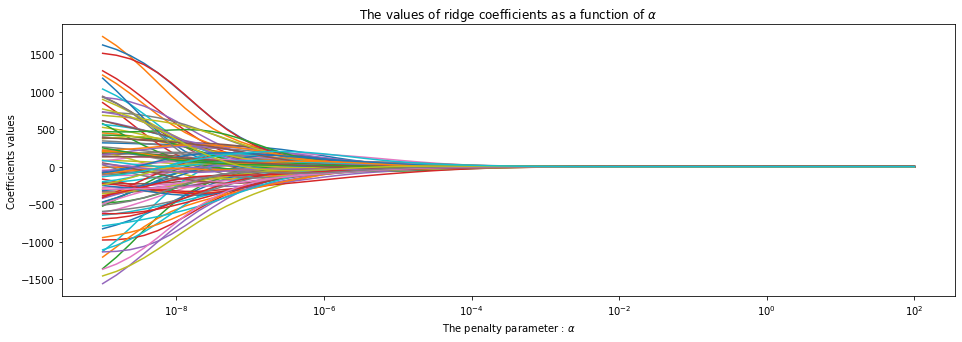

In [18]:
#----- How the coefficients change with alpha -----#

n_alphas = 60
plot_alphas = np.logspace(-9, 2, num=n_alphas)

fig = plt.figure(figsize=(16,5))

for i in range(p-1) : # The i-th coefficient of theta_hat
    Theta_i = []
    for k in range(len(plot_alphas)) :
        Theta_i.append(ridge(X_train, Y_train, plot_alphas[k])[i])
    plt.plot(plot_alphas, Theta_i)

plt.xlabel(r"The penalty parameter : $\alpha$")
plt.ylabel("Coefficients values")
plt.xscale('log')
plt.title(r"The values of ridge coefficients as a function of $\alpha$")

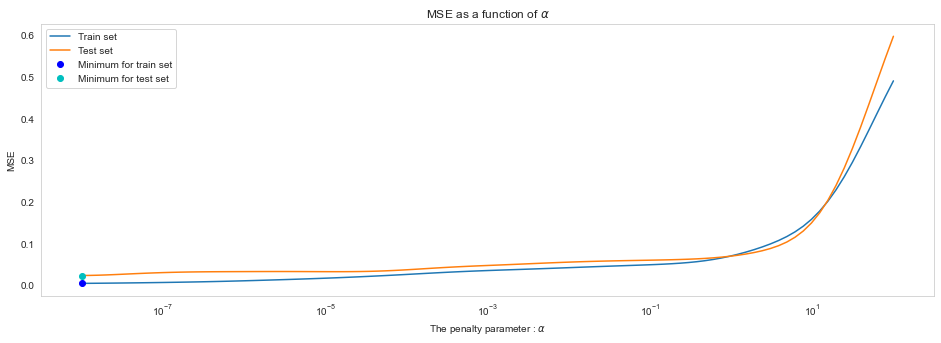

In [39]:
#----- MSE of both train and test sets -----#

n_alphas = 100
alphas = np.logspace(-8, 2, num=n_alphas)


MSE_train = []
MSE_test = []
for k in range(len(alphas)) :
    theta_hat = ridge(X_train, Y_train, alphas[k])
    Y_train_hat = X_train @ theta_hat
    Y_test_hat = X_test @ theta_hat
    err_train = mse(Y_train_hat, Y_train)
    err_test = mse(Y_test_hat, Y_test)
    MSE_train.append(err_train)
    MSE_test.append(err_test)
    
min_train = MSE_train.index(min(MSE_train))
min_test = MSE_test.index(min(MSE_test))

fig = plt.figure(figsize=(16,5))
plt.plot(alphas, MSE_train, label = 'Train set')
plt.plot(alphas, MSE_test, label = 'Test set')
plt.plot(alphas[min_train], MSE_train[min_train], 'bo', label = 'Minimum for train set')
plt.plot(alphas[min_train], MSE_test[min_train], 'co', label = 'Minimum for test set')
plt.xlabel(r"The penalty parameter : $\alpha$")
plt.ylabel("MSE")
plt.xscale('log')
plt.title(r"MSE as a function of $\alpha$")
plt.legend()

In [40]:
#----- R² for the best performing value of the Ridge regularization parameter -----# 

alpha_best = alphas[min_train]
theta_ridge = ridge(X_train, Y_train, alpha_best)
Y_predicted_ridge = X_test @ theta_ridge
r2_ridge = r_2(Y_predicted_ridge, Y_test)
df_coef["Ridge"] = r2_ridge
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection,Ridge,Lasso,PCA before OLS
0,0.960055,0.95518,0.93873,0.976246,0.926019,0.97746


#### Crossvalidation, Lasso and elastic net :

#### Q6 :

In [21]:
#----- Performing the Lasso -----#

n_alphas = 60
lasso_alphas = np.logspace(-5, -2, num=n_alphas)

thetas_nz = []

MSE_train_lasso = []
MSE_test_lasso = []

for alpha in lasso_alphas :
    lasso_k = Lasso(alpha, fit_intercept = False, max_iter = 1e5, tol=0.05)
    lasso_k.fit(X_train, Y_train)
    theta_hat = lasso_k.coef_
    
    count_nz = 0
    for t_ in theta_hat:
        if t_ != 0 : count_nz += 1
    thetas_nz.append(count_nz)
   
    Y_train_pred = lasso_k.predict(X_train)
    Y_test_pred = lasso_k.predict(X_test)
    err_train = mse(Y_train, Y_train_pred)
    err_test = mse(Y_test, Y_test_pred)
    MSE_train_lasso.append(err_train)
    MSE_test_lasso.append(err_test)

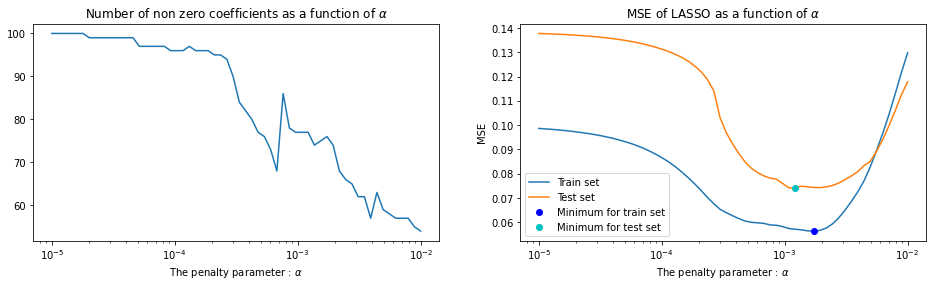

In [22]:
#----- Plotting the results -----#

min_train_lasso = min(MSE_train_lasso)
min_test_lasso = min(MSE_test_lasso)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axes[0].plot(lasso_alphas, thetas_nz)
axes[0].set_xlabel(r"The penalty parameter : $\alpha$")
axes[0].set_title(r"Number of non zero coefficients as a function of $\alpha$")
axes[0].set_xscale('log')


axes[1].plot(lasso_alphas, MSE_train_lasso, label = 'Train set')
axes[1].plot(lasso_alphas, MSE_test_lasso, label = 'Test set')
axes[1].plot(lasso_alphas[MSE_train_lasso.index(min_train_lasso)], min_train_lasso, 'bo', label = 'Minimum for train set')
axes[1].plot(lasso_alphas[MSE_test_lasso.index(min_test_lasso)], min_test_lasso, 'co', label = 'Minimum for test set')
axes[1].set_xlabel(r"The penalty parameter : $\alpha$")
axes[1].set_ylabel("MSE")
axes[1].set_xscale('log')
axes[1].set_title(r"MSE of LASSO as a function of $\alpha$")
axes[1].legend()

In [23]:
#----- R² for the best performing value of the Lasso regularization parameter -----# 

alpha_lasso = lasso_alphas[MSE_train_lasso.index(min_train_lasso)]
lasso = Lasso(alpha_lasso, fit_intercept = False, max_iter = 1e5, tol=0.05)
lasso.fit(X_train, Y_train)
Y_predicted_lasso = lasso.predict(X_test)
r2_lasso = lasso.score(X_test, Y_test)
df_coef["Lasso"] = r2_lasso
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection,Ridge,Lasso
0,0.960055,0.95518,0.93873,0.976246,0.926019


#### Q7 :

In [37]:
#----- Cross validation & ElasticNet -----#

K = 10
r = 200

cv_ridge_alphas = np.logspace(-10, 3, num=r)
cv_lasso_alphas = [0, 0.1, 0.5, 0.7, 0.9, 0.99]


Errors = []
for a_lasso in cv_lasso_alphas :
    Errors_ridge = []
    for a_ridge in cv_ridge_alphas :
        Errors_k = []
        for k in range(K) : 
            delta = len(X_train)//K
            indices = range(k*delta, (k+1)*delta)
            X_cv_k = np.reshape(np.delete(X_train, indices, axis=0), (X_train.shape[0]-delta, X_train.shape[1]))
            # We are deleting delta lines from X_train --> we need to reshape after
            Y_cv_k = np.delete(Y_train, indices)
            
            elastic_net = ElasticNet(alpha = a_lasso + a_ridge, l1_ratio = a_lasso/(a_lasso + a_ridge), 
                                     fit_intercept = False, max_iter = 10e4, tol = 10-5)
            elastic_net.fit(X_cv_k, Y_cv_k)
            
            Y_cv_pred = elastic_net.predict(X_train[k*delta:(k+1)*delta]) # We test on the "deleted" fold
            err = mse(Y_cv_pred, Y_train[k*delta:(k+1)*delta])
            Errors_k.append(err)
        Errors_ridge.append(np.mean(Errors_k))
    Errors.append(Errors_ridge)

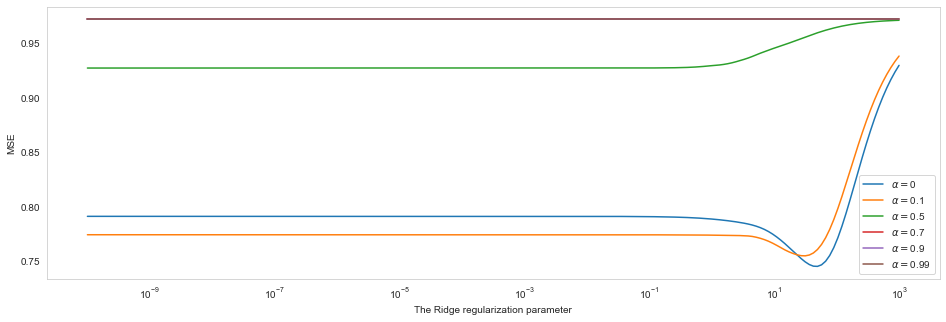

In [38]:
fig = plt.figure(figsize=(16,5))
for k in range(len(cv_lasso_alphas)) :
    plt.plot(cv_ridge_alphas, Errors[k], label = r'$\alpha = $' + f'{cv_lasso_alphas[k]}')
    plt.ylabel('MSE')
    plt.xlabel('The Ridge regularization parameter')
    plt.xscale('log')
    plt.legend()

#### Bootstrap :

#### Q8 :

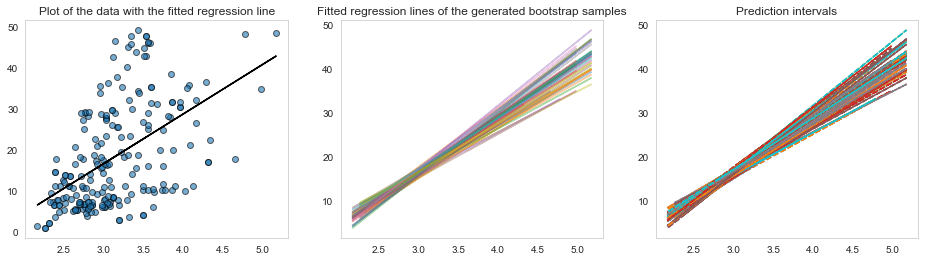

In [50]:
#----- Bootstrap & Prediction Intervals -----#

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

Xb = X.T[40]
reg = LinearRegression(fit_intercept=True)
reg.fit(Xb.reshape(-1, 1), Y)
Y_pred = reg.predict(Xb.reshape(-1, 1))
axes[0].scatter(Xb, Y, alpha=0.6, edgecolors="k")
axes[0].plot(Xb, Y_pred, color='k')
axes[0].set_title("Plot of the data with the fitted regression line")

B = 50
alpha_bis = 0.9


for k in range(B) :
    
    #-- Regression on the generated bootstrap samples --#
    Xk = np.zeros(Xb.shape)
    Yk = np.zeros(Y.shape)
    n = Xk.shape[0]
    for i in range(n) :
        r = np.random.randint(0, n)
        Xk[i] = Xb[r] 
        Yk[i] = Y[r]
    reg_k = LinearRegression(fit_intercept=True)
    reg_k.fit(Xk.reshape(-1, 1), Yk)
    Yk_pred = reg_k.predict(Xk.reshape(-1, 1))
    axes[1].plot(Xk, Yk_pred, alpha=0.4)
    axes[1].set_title("Fitted regression lines of the generated bootstrap samples")
    
    #-- Prediction intevals ---#
    Xk_bar = np.mean(Xk)
    Yk_bar = np.mean(Yk)
    Xk_var = sum((Xk - Xk_bar)**2)
    
    beta_0 = reg_k.intercept_
    beta_1 = reg_k.coef_
    sigma_hat = np.sqrt((sum(Yk - Yk_pred)**2) / (n-2))
    
    beta0_sd = sigma_hat * np.sqrt(1/n + Xk_bar**2/Xk_var)
    beta1_sd = sigma_hat / np.sqrt(Xk_var)

    t_alpha = t.ppf(1-alpha_bis/2, n-2, loc = beta_1, scale = beta1_sd)
    p_low = Yk_pred - t_alpha*sigma_hat*np.sqrt(1 + 1/n + (Xk-Xk_bar)**2/Xk_var)
    p_up = Yk_pred + t_alpha*sigma_hat*np.sqrt(1 + 1/n + (Xk-Xk_bar)**2/Xk_var)
    axes[2].plot(Xk, p_low, '--', label = 'Prediction interval')
    axes[2].plot(Xk, p_up, '--')
    axes[2].set_title("Prediction intervals")

#### PCA :

#### Q9 :

In [27]:
#----- SVD -----#
G = X_train.T @ X_train / n # The covariance matrix is the Gram matrix 
U, s, V = np.linalg.svd(G, hermitian=True)

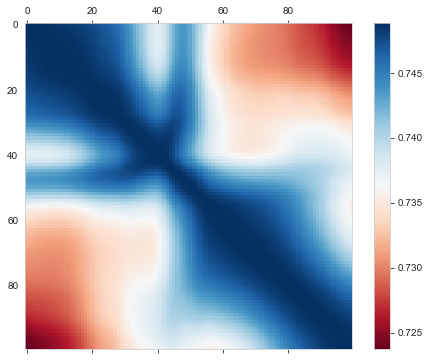

In [28]:
#----- Heatmap of the covariance matrix -----#

fig = plt.figure(figsize=(8, 6))
sns.set_style("whitegrid", {'axes.grid': False})
ax = fig.add_subplot()
heatmap = ax.matshow(G, cmap="RdBu") 
fig.colorbar(heatmap) 
plt.show()

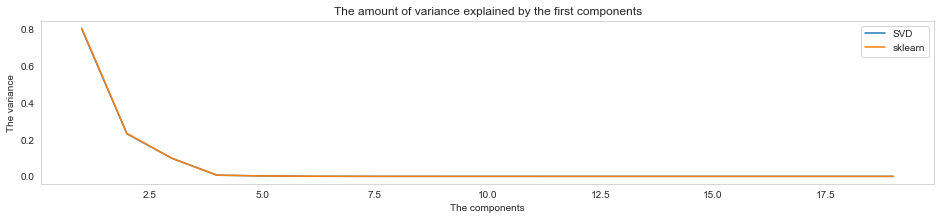

In [63]:
#----- plot of the variance explained by the first k components ; k = 2, ..., p -----#

fig = plt.figure(figsize=(16,3))

# Using SVD
n, p = X_train.shape
PC = X_train @ U
plt.plot(np.arange(p)[1:20], np.var(PC, axis=0)[1:20], label='SVD')

# Using sklearn
pca_all = PCA(n_components=p)
pca_all.fit_transform(X_train)
plt.plot(np.arange(p)[1:20], pca_all.explained_variance_[1:20], label='sklearn')

plt.xlabel('The components')
plt.ylabel('The variance')
plt.title('The amount of variance explained by the first components')
plt.legend()

In [65]:
pca = PCA(n_components=2)
components = pca.fit_transform(X_train) # To keep only the 2 features selected

fig = px.scatter(components, color = Y_train.flatten())
fig.show()

print(pca.explained_variance_)

[99.47699954  0.80574549]


In [31]:
#---- R² of PCA before OLS -----#

nb_components = np.arange(2, p)
scores = []

for k in nb_components :
    pca_k = PCA(n_components=k)
    X_pca = pca_k.fit_transform(X_train) 
    X_pca_test = pca_k.transform(X_test) # Applying the dimensionality reduction to the test set
    ols_after_pca = LinearRegression(fit_intercept=False)
    ols_after_pca.fit(X_pca, Y_train)
    score = ols_after_pca.score(X_pca_test, Y_test)
    scores.append(score)
    
df_coef["PCA before OLS"] = max(scores)
df_coef

,Regular OLS,Forward variable selection,Sequential variable selection,Ridge,Lasso,PCA before OLS
0,0.960055,0.95518,0.93873,0.976246,0.926019,0.97746


#### Comparison of the models :

All of the models give a very good determination score (> 0.9). This means that, generally, using linear regression is more or less a sufficient way to predict the value of the variable 'fat' with the covariates we have.

Based on the R² only, the best method to use is PCA before OLS (and Ridge), and the least performant model is LASSO.

***1.Regular OLS :*** It is the best linear unbiased estimator (the estimates of the coefficients are unbiased and have minimum variance among all linear unbiased estimators).

***2.Variable Selection :***  It is used to identify important variables that have a significant effect on the outcome of a model. For that purpose, in FVS, we use the test of no effect to test if a prediction $\theta_k$ is null, in which case this coefficient has no effect in the prediction by the OLS.

***3. Regularization :*** Adds a penalty term to the objective function that is used to train the model. This penalty term, which is  based on the magnitude of the weights, helps to prevent overfitting by penalizing increasingly complex models. The regularization parameter can be tuend to obtain the best model performance on the training dataset. 

	+ Ridge : Allows to reduce the impact of multicolinearity. It shrinks the magnitude of coefficients, but it doesn’t reduce the coefficients to zero. Compared to regular OLS, the Ridge Estimator is biased with smaller variance. Therefore, we have a Bias-Variance tradeoff
    + LASSO : It reduces the number of predictors by setting some coefficients to zero, thus eliminating the least important predictors from the model. It is particularly adapted in high dimension. The main disadvantage of LASSO is that it is sensitive to outliers and can lead to biased estimates. Lasso is particularly adapted in high dimension (in-built variable selection).
    + ElasticNet : It is a combination of Ridge and LASSO regression, which can be used to perform both variable selection and parameter shrinkage.
    
***4. K-fold Cross Validation :*** It is used to assess the accuracy of a predictive model by splitting the data set into multiple training and test sets. We have used it for model selection with ElasticNet as it can help to identify the best model parameters and reduce generalization errors.

***5. PCA before OLS :*** It is used to reduce the complexity of a dataset by removing redundant features and reducing the number of variables to a necessary minimum by identifying patterns in data and maximizing the variance of the data. The goal is to reduce the data dimensions and to minimize the loss of information in the dataset.